# Modele Generatywne

## Import + CUDA

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [1]:
import os
import json
import math
import random
import numpy as np
import pandas as pd

# Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# Torchvision
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


## Przygotowanie danych

In [4]:
# Image => Tensor
transform = transforms.Compose([transforms.ToTensor()])

# Loading training set, splitting
train_dataset = FashionMNIST(root="data/", train=True, transform=transform, download=True)

# Loading the test set
test_set = FashionMNIST(root="data/", train=False, transform=transform, download=True)

# Data loaders
train_loader = data.DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

def get_train_images(num):
    return torch.stack([test_set[i][0] for i in range(10,10+num)], dim=0)

## Autoenkoder waraicyjny

VAE tak samo jak zwykły autoenkoder zbudowany jest z enkodera który mapuje wejściowe obrazki **x** w niskowymiarową przestrzeń ukrytą **z**, oraz dekodera który odwraca tę operację i rekonstruuje wejście **x** z przestrzeni ukrytej **z**.

### Stworzenie kodera
Koder zwraca wektor średnich i wektor logarytów wariancji dla macierzy kowariancji dla rozkładu normalnego.

Zwracanie logarytmów zapewnia, że będą lepsze różnice.

In [80]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean  = nn.Linear(hidden_dim, latent_dim)
        self.fc_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x       = self.LeakyReLU(self.fc_1(x))
        x       = self.LeakyReLU(self.fc_2(x))
        mean     = self.fc_mean(x)
        log_var  = self.fc_var(x)
        
        return mean, log_var

### Stworzenie dekodera
+ Bierze próbki wylosowane z rozkładem.

In [81]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))
        
        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 1, 28, 28])
        return x_hat
        

### Pełen autoenkoder wariacyjny

In [82]:
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

    def reparameterization(self, mean, std):
        z = torch.normal(mean, std)
        return z

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

In [14]:
vae = VAE(latent_dim=32, hidden_dim=256, x_dim=784).to(device)

## Trening autoenkodera wariacyjnego

In [15]:
criterion = nn.MSELoss(reduction="sum")
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [22]:
def train_vae(vae_model, vae_criterion, vae_optimizer, vae_scheduler, vae_train_loader, vae_test_loader, n_epochs):
    for epoch in range(n_epochs):
        losses_epoch = []
        for x, _ in iter(vae_train_loader):
            x = x.to(device)
            out, means, log_var = vae_model(x)
            loss = vae_criterion(out, x)
            losses_epoch.append(loss.item())
            loss.backward()
            vae_optimizer.step()
            vae_optimizer.zero_grad()
        L1_list = []
        for x, _ in iter(vae_test_loader):
            x  = x.to(device)
            out, _, _ = vae(x)
            L1_list.append(torch.mean(torch.abs(out-x)).item())
        print(f"Epoch {epoch} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
        vae_scheduler.step()

In [16]:
num_epochs = 30
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = criterion(out, x) 
        losses_epoch.append(loss.item())
        loss.backward()               
        optimizer.step()             
        optimizer.zero_grad()  
    L1_list = []
#     if n % 10 == 0:
    for x, _ in iter(test_loader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

Epoch 0 loss 18150.8195446047, test L1 = 0.2311742164194584
Epoch 1 loss 17499.423460870727, test L1 = 0.23077301681041718
Epoch 2 loss 17470.85118689904, test L1 = 0.23162658475339412
Epoch 3 loss 17460.898404113246, test L1 = 0.229725893586874
Epoch 4 loss 17458.43690738515, test L1 = 0.23157581463456153
Epoch 5 loss 17441.811435797277, test L1 = 0.23250575065612794
Epoch 6 loss 17442.5179286859, test L1 = 0.23255245685577391
Epoch 7 loss 17430.29946247329, test L1 = 0.23236747980117797
Epoch 8 loss 17430.21089576656, test L1 = 0.23365196585655212
Epoch 9 loss 17430.69862613515, test L1 = 0.2322680674493313
Epoch 10 loss 17423.657251602563, test L1 = 0.23131463192403318
Epoch 11 loss 17427.0583850828, test L1 = 0.231347830966115
Epoch 12 loss 17421.88797492655, test L1 = 0.23170757479965687
Epoch 13 loss 17428.264247796473, test L1 = 0.23089942410588266
Epoch 14 loss 17415.0182041266, test L1 = 0.2307287346571684
Epoch 15 loss 17418.095469417734, test L1 = 0.22978013418614865
Epoch 1

In [5]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, means, log_var = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()
    
    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

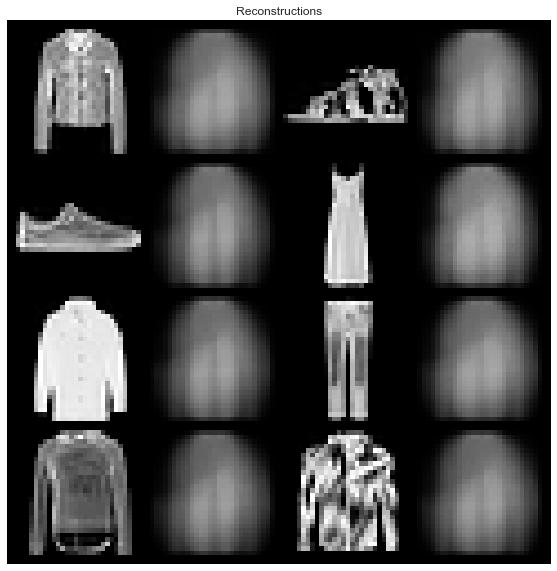

In [18]:
input_imgs = get_train_images(8)
visualize_reconstructions(vae, input_imgs, device)

Możemy zauważyć, że nie ma tu żadnej nauki - rekonstrukcje w formie zwizualizowanej wyglądają źle.
Gradienty są zerowane - liczenie pochodnej na losowaniu z rozkładu normalnego jest niewykonywalne - losowanie nie ma pochodnej - enkoder nigdy nie jest dotrenowywany.

In [20]:
wrong_x = torch.randn(10, requires_grad=True)
wrong_y = torch.normal(wrong_x, torch.randn(10)+5)
(wrong_y-torch.ones(10)).mean().backward()
wrong_x.grad

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Rozwiązanie problemu - tzw. reparametrization trick - losujemy z boku - nie będą nas w trakcie liczenia gradientu interesowały.

In [77]:
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)


    def reparameterization(self, mean, std):
        z = mean + std * torch.randn_like(std).to(device)
        return z


    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

In [23]:
vae = VAE(latent_dim=32, hidden_dim=256, x_dim=784).to(device)
criterion = nn.MSELoss(reduction="sum")
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)
train_vae(vae, criterion, optimizer, scheduler, train_loader, test_loader, 30)

Epoch 0 loss 8953.685023120326, test L1 = 0.09293576050549746
Epoch 1 loss 4417.913483448518, test L1 = 0.07981362082064151
Epoch 2 loss 3687.223901993189, test L1 = 0.073603711463511
Epoch 3 loss 3303.083781967815, test L1 = 0.0692459087818861
Epoch 4 loss 3056.1792732956064, test L1 = 0.06618744507431984
Epoch 5 loss 2840.620667025574, test L1 = 0.06392300939187408
Epoch 6 loss 2676.51997779781, test L1 = 0.062118735164403915
Epoch 7 loss 2550.3163300864717, test L1 = 0.05972031923010945
Epoch 8 loss 2429.3875429854434, test L1 = 0.058390758279711005
Epoch 9 loss 2344.892627161792, test L1 = 0.057391924876719715
Epoch 10 loss 2268.309280786759, test L1 = 0.056316950172185895
Epoch 11 loss 2210.5055030757544, test L1 = 0.05552002601325512
Epoch 12 loss 2150.4107952933027, test L1 = 0.05471536787226796
Epoch 13 loss 2100.1097182575454, test L1 = 0.053936425037682055
Epoch 14 loss 2054.012664534088, test L1 = 0.05341960731893778
Epoch 15 loss 2014.0872729700855, test L1 = 0.052785384468

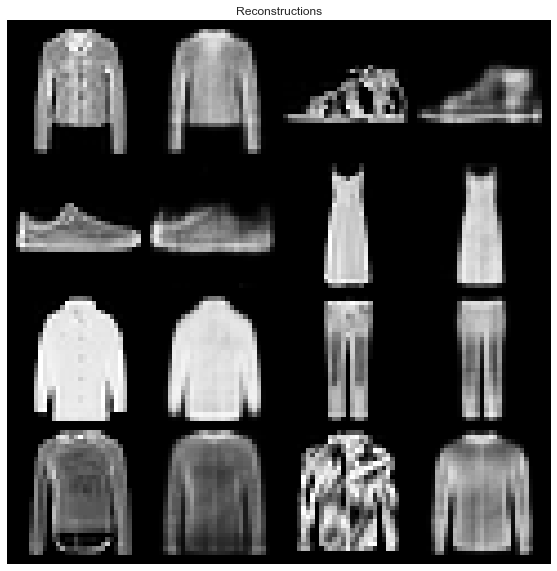

In [24]:
input_imgs = get_train_images(8)
visualize_reconstructions(vae, input_imgs, device)

In [25]:
torch.save(vae.state_dict(),"models/vae_1")

In [26]:
# vae = VAE(latent_dim=32, hidden_dim=256, x_dim=784).to(device)
# vae.load_state_dict(torch.load("models/vae_1"))

Rekonstrukcje nie są skomplikowane - chcemy generować obrazki.
Aby to zrobić - podajmy szum dekoderowi.

In [6]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(torch.randn([n_imgs, model.latent_dim]).to(device))
    generated_imgs = generated_imgs.cpu()

    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

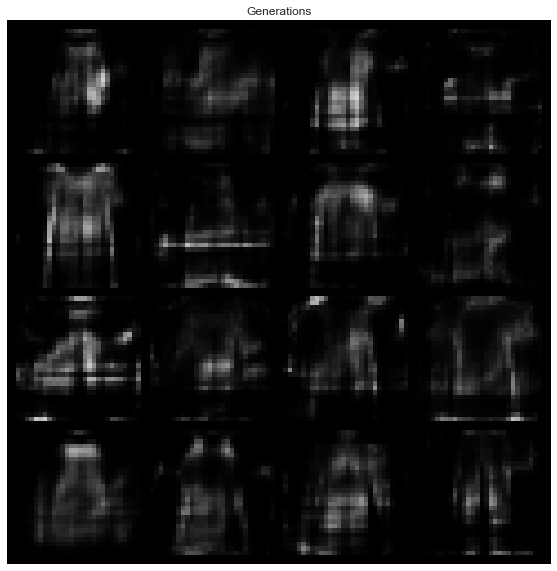

In [28]:
generate_images(vae, 16 , device)

Dostajemy słabe wyniki. Problem - używamy złej funkcji straty, brakuje nam regularyzacji na przestrzeni ukrytej, która wymusi rozkład normalny o średnich 0 i macierzy kowariancji jednostkowej - wtedy będziemy mogli losować z dowolnego miejsca.

Aktualna funkcja straty powoduje, że nasze odchylenia standardowe są ok. równe 0 - bo wtedy ten szum w reparametrization trick jest prawie zerowy.

### Funkcja straty z Dywergencją K-L

In [7]:
def vae_loss_function(x, x_out, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_out, x, reduction='sum')
    div_KL =  -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + div_KL

Dodatkowo zwiększymy przestrzeń ukrytą. Ogólnie mamy tutaj pewien kompromis - nie moze być nasza przestrzeń ukryta za duża, ale często zwiększanie daje lepsze wyniki.

In [44]:
import copy
vae_32 = copy.deepcopy(vae)

In [45]:
vae = VAE(latent_dim=16, hidden_dim=256, x_dim=784).to(device)

In [46]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [47]:
def train_vae_KLD(vae_model, vae_optimizer, vae_scheduler, vae_train_loader, vae_test_loader, n_epochs=30):
    for epoch in range(n_epochs):
        losses_epoch = []
        for x, _ in iter(vae_train_loader):
            x = x.to(device)
            out, means, log_var = vae_model(x)
            loss = vae_loss_function(x, out, means, log_var)
            losses_epoch.append(loss.item())
            loss.backward()               # backward pass (compute parameter updates)
            vae_optimizer.step()              # make the updates for each parameter
            vae_optimizer.zero_grad()
        L1_list = []
        for x, _ in iter(vae_test_loader):
            x  = x.to(device)
            out, _, _ = vae(x)
            L1_list.append(torch.mean(torch.abs(out-x)).item())
        print(f"Epoch {epoch} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
        vae_scheduler.step()

In [48]:
train_vae_KLD(vae, optimizer, scheduler, train_loader, test_loader)

Epoch 0 loss 11817.531454493857, test L1 = 0.11413912698626519
Epoch 1 loss 7576.245580428686, test L1 = 0.10081842262297869
Epoch 2 loss 6998.649760450054, test L1 = 0.09516722802072763
Epoch 3 loss 6784.291862813836, test L1 = 0.09276263993233443
Epoch 4 loss 6651.462596404247, test L1 = 0.0888266721740365
Epoch 5 loss 6561.217520950187, test L1 = 0.08857534844428301
Epoch 6 loss 6489.556586371527, test L1 = 0.08701508957892656
Epoch 7 loss 6433.303422976763, test L1 = 0.08490598052740098
Epoch 8 loss 6385.016088241186, test L1 = 0.08654351364821196
Epoch 9 loss 6348.8294521233975, test L1 = 0.08588378671556711
Epoch 10 loss 6317.591627854567, test L1 = 0.08433019146323203
Epoch 11 loss 6287.812635633681, test L1 = 0.08390694800764323
Epoch 12 loss 6259.903291099092, test L1 = 0.08360600676387549
Epoch 13 loss 6242.812124399038, test L1 = 0.08257634434849023
Epoch 14 loss 6224.668118990385, test L1 = 0.0821879742667079
Epoch 15 loss 6199.212715344552, test L1 = 0.08187568113207817
Ep

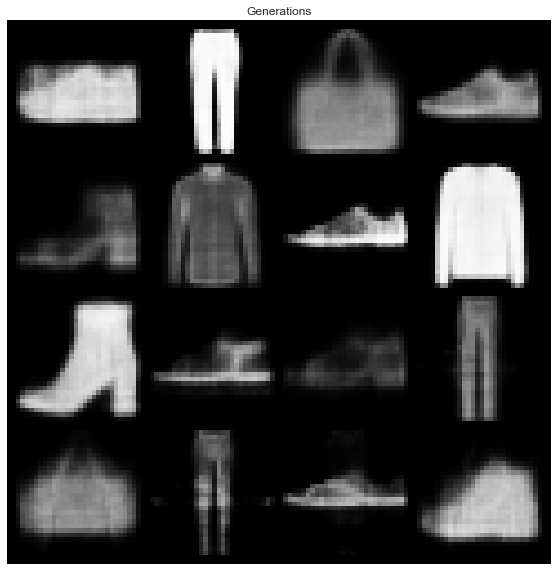

In [49]:
generate_images(vae, 16 , device)

+ Nie mamy tu już tak dobrego lossa - ale na tym nam nie zależy.

### Przestrzeń ukryta VAE

In [50]:
def embed_imgs(model, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []
    model.eval()
    labels = []
    for imgs, label in data_loader:
        with torch.no_grad():
            mean, var_log = model.encoder(imgs.to(device))
        img_list.append(imgs)
        embed_list.append(mean)
        labels.append(label)
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0), torch.cat(labels, dim=0))


In [8]:
import umap
import pandas as pd
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

In [52]:
umap_object = umap.UMAP(metric="cosine", n_neighbors=100)
train_img_embeds = embed_imgs(vae, train_loader)
test_img_embeds = embed_imgs(vae, test_loader)
train_embedded = umap_object.fit_transform(train_img_embeds[1][:5000].cpu())

In [53]:
def plot_latent(train_embedded, train_img_embeds, n_data=5000):
    data = pd.DataFrame(train_embedded[:n_data])
    data["label"] = train_img_embeds[2][:n_data].cpu().numpy()
    examples = []
    examples_locations = []
    for i in np.random.randint(0,n_data,40):
        examples.append(train_img_embeds[0][i].squeeze(0).cpu().numpy())
        examples_locations.append(data.iloc[i])
    fig, ax = plt.subplots(figsize=(12, 10))
    # ax.scatter(noises_to_plot_tsne[0],noises_to_plot_tsne[1],c=noises_to_plot_tsne["batch"],s=3,alpha=0.8)
    sns.scatterplot(
        x=0, y=1,
        hue="label",
        palette=sns.color_palette("hls", 10),
        data=data,
        legend="full",
        alpha=0.1
    )
    for location, example in zip(examples_locations, examples):
        x, y = location[0], location[1]
        label = int(location["label"])
        ab = AnnotationBbox(OffsetImage(example,cmap=plt.cm.gray_r, zoom=1), (x, y), frameon=True,
                            bboxprops=dict(facecolor=sns.color_palette("hls", 10)[label], boxstyle="round"))
        ax.add_artist(ab)
    plt.show()

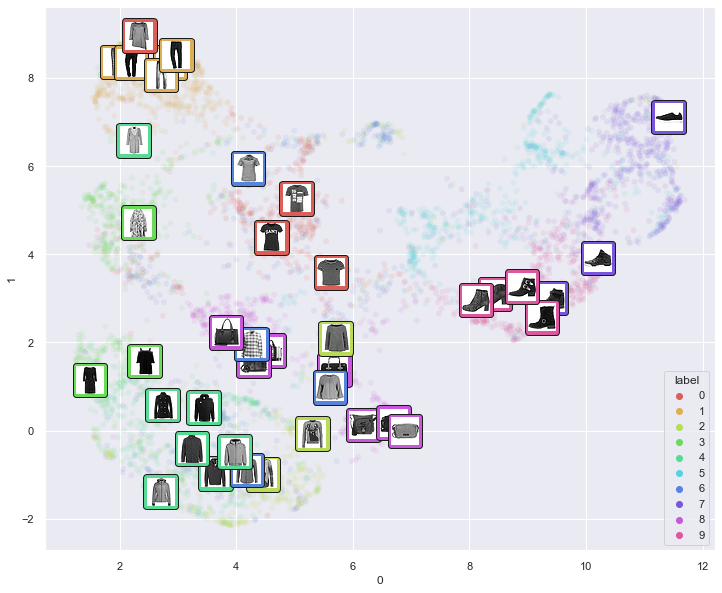

In [54]:
plot_latent(train_embedded, train_img_embeds)

Zauważmy, że zgrupowania tutaj są jeszcze bardziej widoczne.

Zobaczmy wizualizację na zdecydowanie mniejszym rozmiarze przestrzeni ukrytej.

In [55]:
vae = VAE(latent_dim=2, hidden_dim=256, x_dim=784).to(device)

In [56]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [57]:
train_vae_KLD(vae, optimizer, scheduler, train_loader, test_loader)

Epoch 0 loss 10806.290022369123, test L1 = 0.1198183199390769
Epoch 1 loss 8257.670666816906, test L1 = 0.11483481097966433
Epoch 2 loss 7974.169318826789, test L1 = 0.11114087365567685
Epoch 3 loss 7749.450445713141, test L1 = 0.10666999276727437
Epoch 4 loss 7604.403447599492, test L1 = 0.10691076666116714
Epoch 5 loss 7463.782656416934, test L1 = 0.10490899868309497
Epoch 6 loss 7391.363498263889, test L1 = 0.10520340017974376
Epoch 7 loss 7311.248207548745, test L1 = 0.10342241898179054
Epoch 8 loss 7269.955520499466, test L1 = 0.10280951131135226
Epoch 9 loss 7223.255623581063, test L1 = 0.10246733389794827
Epoch 10 loss 7195.5712327223555, test L1 = 0.10186946671456099
Epoch 11 loss 7163.4707761585205, test L1 = 0.10113215185701847
Epoch 12 loss 7134.480260082799, test L1 = 0.1006553240120411
Epoch 13 loss 7111.2567795973555, test L1 = 0.10096766501665115
Epoch 14 loss 7098.639692257612, test L1 = 0.10071040634065867
Epoch 15 loss 7067.500342214209, test L1 = 0.10043356157839298


In [ ]:
num_epochs = 30
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = vae_loss_function(x, out, means, log_var) 
        losses_epoch.append(loss.item())
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()  
    L1_list = []
#     if n % 10 == 0:
    for x, _ in iter(test_loader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

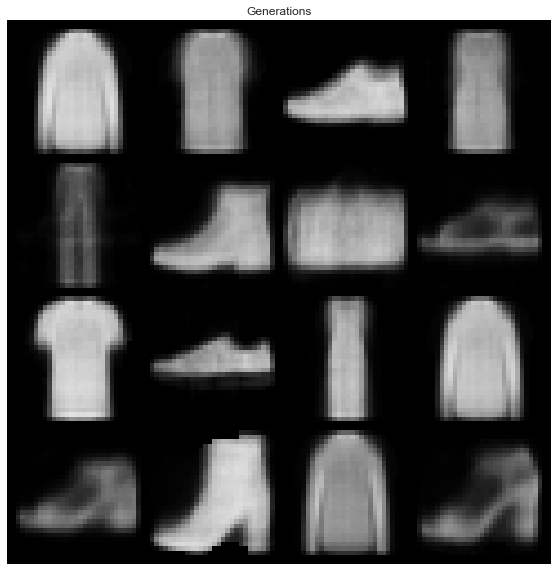

In [58]:
generate_images(vae, 16 , device)

In [59]:
train_img_embeds = embed_imgs(vae, train_loader)
test_img_embeds = embed_imgs(vae, test_loader)
train_embedded = train_img_embeds[1][:5000].cpu()

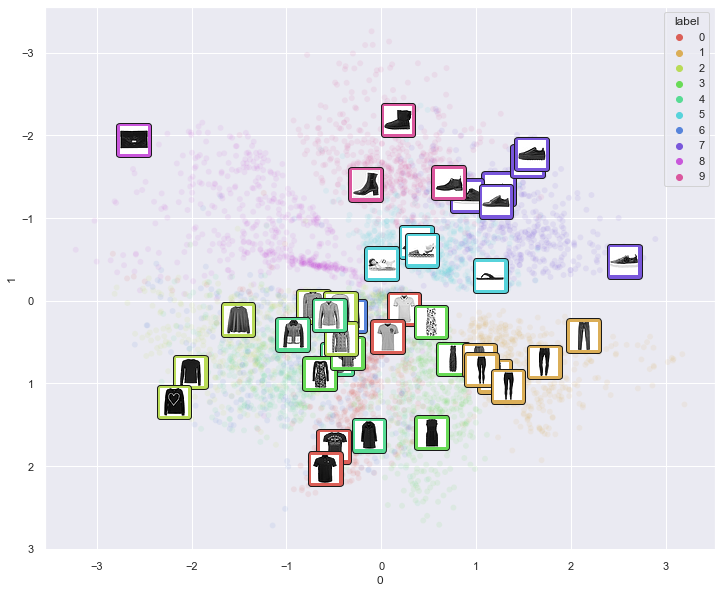

In [60]:
plot_latent(train_embedded, train_img_embeds)

Przestrzeń ukryta pokazuje jak podobne obrazki są umieszczane w podobnych obrazach.

Wizualizacja z podziałem na klasy.
Przypomina to rozkład normalny, gdzie najwiecej punktów mamy na środku i różne klasy są od środka rozciągane.

<AxesSubplot:xlabel='0', ylabel='1'>

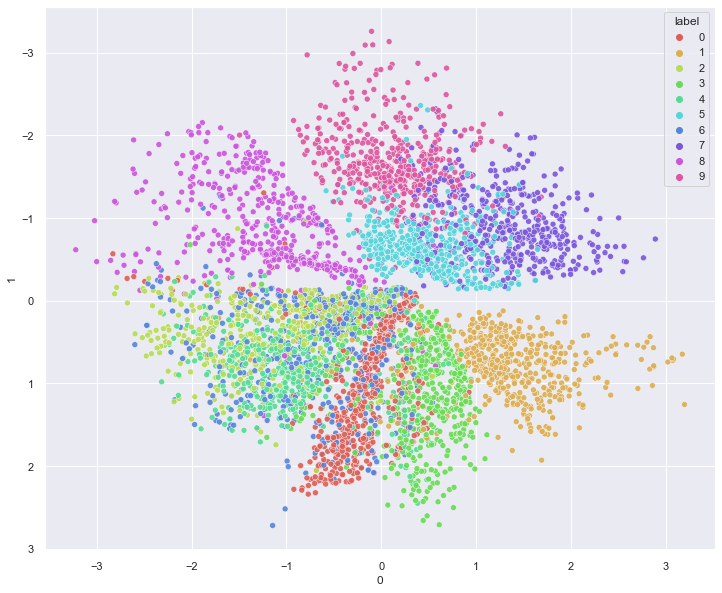

In [61]:
data = pd.DataFrame(train_embedded[:5000])
data["label"] = train_img_embeds[2][:5000].cpu().numpy()
fig, ax = plt.subplots(figsize=(12, 10))
# ax.scatter(noises_to_plot_tsne[0],noises_to_plot_tsne[1],c=noises_to_plot_tsne["batch"],s=3,alpha=0.8)
sns.scatterplot(
    x=0, y=1,
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=data,
    legend="full",
    alpha=0.9
)

Problem - trudno będzie stworzyć interpolację między butami a spodniami.

## GANy - Generative Adversarial Networks

Dyskryminator odróżnia złe obrazki od dobrych - odpowiednio syntetycznie stworzone od typowych próbek danych.

In [2]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out  = nn.Linear(hidden_dim, 1)
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        x = self.fc_out(x)
        return x

Generator generuje obrazy syntetyczne jak najbardziej podobne do oryginałów.
Generator uczymy tak, że tworzymy obrazek i przekazujemy go dyskryminatorowi - dążymy do tego, żeby dyskryminator zwrócić prawdopodobieństwo bycia obrazkiem oryginalnym bliskie 1.

W oparciu o loss między targetem a decyzją dyskryminatora uczymy tylko generator, dyskryminator zamrażamy.
Na zmianę dyskryminatorowi przekazujemy obrazki sztuczne (z etykietą 0) i rzeczywiste (z etykietą 1) i na podstawie loss uczymy juz dyskryminator. Robimy to na zmianę, bo chcemy je równomiernie uczyć - żeby dyskryminator zwracał uwage na nowe feature'y jakei maja sztuczne obrazki, wylapal je -> wtedy generator bedzie wiedzial ze nie moze tak zrobić i to zmieni, itd.

### Generator i Dyskryminator

In [86]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))
        
        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 1, 28, 28])
        return x_hat

### Uczenie

Mamy dwa oddzielne optymalizatory dla dwóch oddzielnych sieci, używane na zmianę

In [87]:
# Models
latent_dim = 32
generator = Generator(latent_dim=latent_dim, hidden_dim=256, output_dim=784).to(device)
discriminator = Discriminator( hidden_dim=256, input_dim=784).to(device)

# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
criterion = nn.MSELoss()

In [88]:
fixed_noise = torch.randn(16, latent_dim,device=device)

Epoch: 0, discrimiantor fake error: 0.0704, discriminator real acc: 0.82


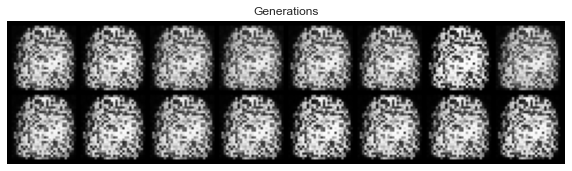

Epoch: 1, discrimiantor fake error: 0.0298, discriminator real acc: 0.94
Epoch: 2, discrimiantor fake error: 0.0187, discriminator real acc: 0.962
Epoch: 3, discrimiantor fake error: 0.00487, discriminator real acc: 0.982
Epoch: 4, discrimiantor fake error: 0.00152, discriminator real acc: 0.993
Epoch: 5, discrimiantor fake error: 0.00186, discriminator real acc: 0.996
Epoch: 6, discrimiantor fake error: 0.00249, discriminator real acc: 0.997
Epoch: 7, discrimiantor fake error: 0.00657, discriminator real acc: 0.994
Epoch: 8, discrimiantor fake error: 0.0174, discriminator real acc: 0.987
Epoch: 9, discrimiantor fake error: 0.0168, discriminator real acc: 0.982
Epoch: 10, discrimiantor fake error: 0.0121, discriminator real acc: 0.984


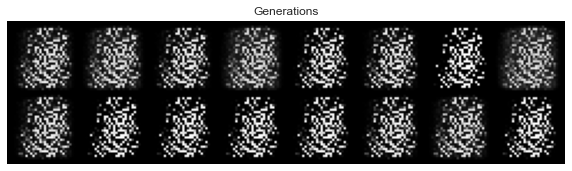

Epoch: 11, discrimiantor fake error: 0.00783, discriminator real acc: 0.99
Epoch: 12, discrimiantor fake error: 0.00811, discriminator real acc: 0.992
Epoch: 13, discrimiantor fake error: 0.0166, discriminator real acc: 0.987
Epoch: 14, discrimiantor fake error: 0.0446, discriminator real acc: 0.963
Epoch: 15, discrimiantor fake error: 0.0395, discriminator real acc: 0.963
Epoch: 16, discrimiantor fake error: 0.0264, discriminator real acc: 0.97
Epoch: 17, discrimiantor fake error: 0.0337, discriminator real acc: 0.971
Epoch: 18, discrimiantor fake error: 0.0625, discriminator real acc: 0.947
Epoch: 19, discrimiantor fake error: 0.0344, discriminator real acc: 0.955
Epoch: 20, discrimiantor fake error: 0.0221, discriminator real acc: 0.971


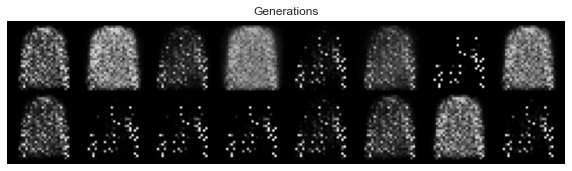

Epoch: 21, discrimiantor fake error: 0.0269, discriminator real acc: 0.972
Epoch: 22, discrimiantor fake error: 0.0322, discriminator real acc: 0.966
Epoch: 23, discrimiantor fake error: 0.0319, discriminator real acc: 0.967
Epoch: 24, discrimiantor fake error: 0.0353, discriminator real acc: 0.968
Epoch: 25, discrimiantor fake error: 0.0402, discriminator real acc: 0.959
Epoch: 26, discrimiantor fake error: 0.0431, discriminator real acc: 0.959
Epoch: 27, discrimiantor fake error: 0.0435, discriminator real acc: 0.956
Epoch: 28, discrimiantor fake error: 0.0365, discriminator real acc: 0.962
Epoch: 29, discrimiantor fake error: 0.0347, discriminator real acc: 0.965
Epoch: 30, discrimiantor fake error: 0.0364, discriminator real acc: 0.964


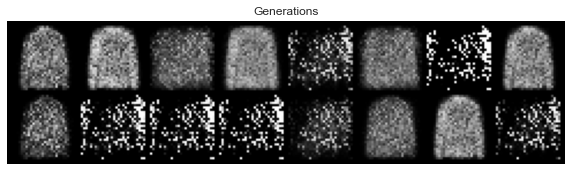

Epoch: 31, discrimiantor fake error: 0.035, discriminator real acc: 0.965
Epoch: 32, discrimiantor fake error: 0.0413, discriminator real acc: 0.961
Epoch: 33, discrimiantor fake error: 0.0442, discriminator real acc: 0.959
Epoch: 34, discrimiantor fake error: 0.0418, discriminator real acc: 0.957
Epoch: 35, discrimiantor fake error: 0.0459, discriminator real acc: 0.958
Epoch: 36, discrimiantor fake error: 0.0405, discriminator real acc: 0.956
Epoch: 37, discrimiantor fake error: 0.0432, discriminator real acc: 0.959
Epoch: 38, discrimiantor fake error: 0.0472, discriminator real acc: 0.955
Epoch: 39, discrimiantor fake error: 0.05, discriminator real acc: 0.951
Epoch: 40, discrimiantor fake error: 0.0491, discriminator real acc: 0.955


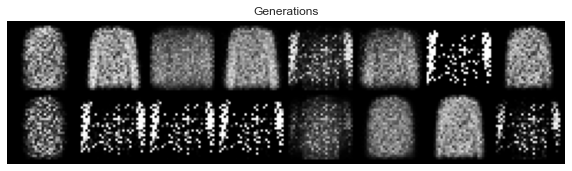

Epoch: 41, discrimiantor fake error: 0.0456, discriminator real acc: 0.954
Epoch: 42, discrimiantor fake error: 0.0437, discriminator real acc: 0.958
Epoch: 43, discrimiantor fake error: 0.044, discriminator real acc: 0.955
Epoch: 44, discrimiantor fake error: 0.0485, discriminator real acc: 0.952
Epoch: 45, discrimiantor fake error: 0.045, discriminator real acc: 0.957
Epoch: 46, discrimiantor fake error: 0.0482, discriminator real acc: 0.95
Epoch: 47, discrimiantor fake error: 0.0453, discriminator real acc: 0.958
Epoch: 48, discrimiantor fake error: 0.0512, discriminator real acc: 0.954
Epoch: 49, discrimiantor fake error: 0.0426, discriminator real acc: 0.957
Epoch: 50, discrimiantor fake error: 0.0492, discriminator real acc: 0.954


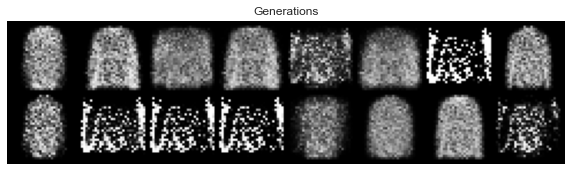

Epoch: 51, discrimiantor fake error: 0.058, discriminator real acc: 0.944
Epoch: 52, discrimiantor fake error: 0.0555, discriminator real acc: 0.947
Epoch: 53, discrimiantor fake error: 0.056, discriminator real acc: 0.946
Epoch: 54, discrimiantor fake error: 0.0595, discriminator real acc: 0.943
Epoch: 55, discrimiantor fake error: 0.0603, discriminator real acc: 0.946
Epoch: 56, discrimiantor fake error: 0.0638, discriminator real acc: 0.937
Epoch: 57, discrimiantor fake error: 0.0687, discriminator real acc: 0.938
Epoch: 58, discrimiantor fake error: 0.0741, discriminator real acc: 0.929
Epoch: 59, discrimiantor fake error: 0.0716, discriminator real acc: 0.933
Epoch: 60, discrimiantor fake error: 0.0747, discriminator real acc: 0.931


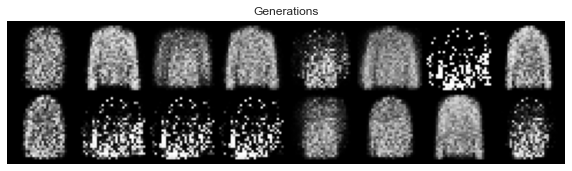

Epoch: 61, discrimiantor fake error: 0.0661, discriminator real acc: 0.935
Epoch: 62, discrimiantor fake error: 0.0659, discriminator real acc: 0.937
Epoch: 63, discrimiantor fake error: 0.0681, discriminator real acc: 0.938
Epoch: 64, discrimiantor fake error: 0.0632, discriminator real acc: 0.939
Epoch: 65, discrimiantor fake error: 0.0615, discriminator real acc: 0.943
Epoch: 66, discrimiantor fake error: 0.0634, discriminator real acc: 0.941
Epoch: 67, discrimiantor fake error: 0.0678, discriminator real acc: 0.932
Epoch: 68, discrimiantor fake error: 0.0635, discriminator real acc: 0.942
Epoch: 69, discrimiantor fake error: 0.0686, discriminator real acc: 0.939
Epoch: 70, discrimiantor fake error: 0.0652, discriminator real acc: 0.938


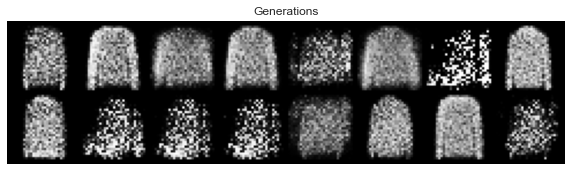

Epoch: 71, discrimiantor fake error: 0.065, discriminator real acc: 0.938
Epoch: 72, discrimiantor fake error: 0.0654, discriminator real acc: 0.939
Epoch: 73, discrimiantor fake error: 0.0683, discriminator real acc: 0.934
Epoch: 74, discrimiantor fake error: 0.0677, discriminator real acc: 0.933
Epoch: 75, discrimiantor fake error: 0.0637, discriminator real acc: 0.937
Epoch: 76, discrimiantor fake error: 0.0663, discriminator real acc: 0.934
Epoch: 77, discrimiantor fake error: 0.064, discriminator real acc: 0.934
Epoch: 78, discrimiantor fake error: 0.0687, discriminator real acc: 0.929
Epoch: 79, discrimiantor fake error: 0.0693, discriminator real acc: 0.932
Epoch: 80, discrimiantor fake error: 0.077, discriminator real acc: 0.924


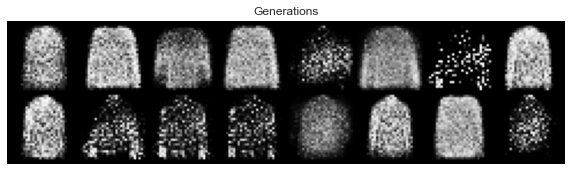

Epoch: 81, discrimiantor fake error: 0.0782, discriminator real acc: 0.922
Epoch: 82, discrimiantor fake error: 0.0875, discriminator real acc: 0.913
Epoch: 83, discrimiantor fake error: 0.085, discriminator real acc: 0.915
Epoch: 84, discrimiantor fake error: 0.0901, discriminator real acc: 0.91
Epoch: 85, discrimiantor fake error: 0.089, discriminator real acc: 0.911
Epoch: 86, discrimiantor fake error: 0.0917, discriminator real acc: 0.908
Epoch: 87, discrimiantor fake error: 0.0903, discriminator real acc: 0.908
Epoch: 88, discrimiantor fake error: 0.0869, discriminator real acc: 0.914
Epoch: 89, discrimiantor fake error: 0.0903, discriminator real acc: 0.909
Epoch: 90, discrimiantor fake error: 0.0989, discriminator real acc: 0.9


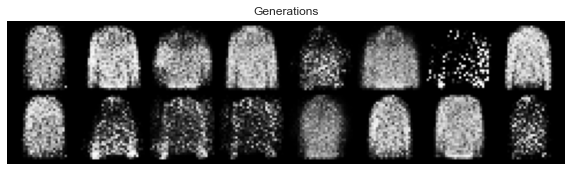

Epoch: 91, discrimiantor fake error: 0.0909, discriminator real acc: 0.913
Epoch: 92, discrimiantor fake error: 0.0988, discriminator real acc: 0.902
Epoch: 93, discrimiantor fake error: 0.0921, discriminator real acc: 0.905
Epoch: 94, discrimiantor fake error: 0.108, discriminator real acc: 0.891
Epoch: 95, discrimiantor fake error: 0.107, discriminator real acc: 0.89
Epoch: 96, discrimiantor fake error: 0.111, discriminator real acc: 0.89
Epoch: 97, discrimiantor fake error: 0.108, discriminator real acc: 0.892
Epoch: 98, discrimiantor fake error: 0.106, discriminator real acc: 0.887
Epoch: 99, discrimiantor fake error: 0.114, discriminator real acc: 0.885


In [89]:
G_losses = []
D_losses = []
num_epochs = 100
for epoch in range(num_epochs):
    # For each batch in the dataloader
    discriminator_fake_acc = []
    discriminator_real_acc = []
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator_optimizer.zero_grad()
        # Format batch
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.ones((b_size,), dtype=torch.float, device=device) # Setting labels for real images -
        # Forward pass real batch through D
        output = discriminator(real_images).view(-1)
        # Calculate loss on all-real batch
        error_discriminator_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        error_discriminator_real.backward()
        discriminator_real_acc.append(output.mean().item())

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dim,device=device)
        # Generate fake image batch with Generator
        fake_images = generator(noise)
        label_fake = torch.zeros((b_size,), dtype=torch.float, device=device)           # fake ones with 0s
        # Classify all fake batch with Discriminator
        output = discriminator(fake_images.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        error_discriminator_fake = criterion(output, label_fake)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        error_discriminator_fake.backward()
        discriminator_fake_acc.append(output.mean().item())
        # Compute error of D as sum over the fake and the real batches
        error_discriminator = error_discriminator_real + error_discriminator_fake

        # Update D - IMPORTANT - OPTIMIZER ONLY HERE - ITS A TRICK THAT ENSURES THAT LEARNING IS BOTH ON REAL AND FAKE IMAGES AT THE SAME MOMENT
        discriminator_optimizer.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator_optimizer.zero_grad()
        label = torch.ones((b_size,), dtype=torch.float, device=device)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake_images).view(-1)
        # Calculate G's loss based on this output
        error_generator = criterion(output, label)
        # Calculate gradients for G
        error_generator.backward()
        D_G_z2 = output.mean().item()
        # Update G
        generator_optimizer.step()

        # Output training stats
        # Save Losses for plotting later
        G_losses.append(error_generator.item())
        D_losses.append(error_discriminator.item())

    print(f"Epoch: {epoch}, discrimiantor fake error: {np.mean(discriminator_fake_acc):.3}, discriminator real acc: {np.mean(discriminator_real_acc):.3}")
    generator_scheduler.step()
    discriminator_scheduler.step()
    if epoch % 10 == 0:
        with torch.no_grad():
            fake = generator(fixed_noise).detach().cpu()
        grid = torchvision.utils.make_grid(fake)
        grid = grid.permute(1, 2, 0)
        plt.figure(figsize=(10,10))
        plt.title(f"Generations")
        plt.imshow(grid)
        plt.axis('off')
        plt.show()

In [90]:
torch.save(generator.state_dict(), "models/generator_1")
torch.save(discriminator.state_dict(), "models/discriminator_1")

In [91]:
final_generator = Generator(latent_dim=latent_dim, hidden_dim=256, output_dim=784).to(device)
final_generator.load_state_dict(torch.load("models/generator_1"))
final_discriminator = Discriminator( hidden_dim=256, input_dim=784).to(device)
final_discriminator.load_state_dict(torch.load("models/discriminator_1"))

<All keys matched successfully>

Model jest czuły zarówno na learning rate, jak i częstości uczenia poszczególnych części.

### Model warunkowany klasą
Na wejście dyskryminatora i generatora podajemy wektor cech.
W naszym przypadku może to być wektor 0 i 1 gdzie 1 oznacza obiekt danej klasy.

In [55]:
numb_classess = len(train_dataset.classes)

In [66]:
class Cond_Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc_1 = nn.Linear(input_dim + 10, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out  = nn.Linear(hidden_dim, 1)
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x, y):
        x = torch.flatten(x, 1)
        x = torch.cat([x,y], 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        x = self.fc_out(x)
        return x

class Cond_Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc_1 = nn.Linear(latent_dim+10, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x, y):
        x = torch.cat([x,y],1)
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))

        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 1, 28, 28])
        return x_hat

In [67]:
# Models
latent_dim = 32
cond_generator = Cond_Generator(latent_dim=latent_dim, hidden_dim=256, output_dim=784).to(device)
cond_discriminator = Cond_Discriminator( hidden_dim=256, input_dim=784).to(device)

# Optimizers
generator_optimizer = torch.optim.Adam(cond_generator.parameters(), lr=0.0001)
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_optimizer = torch.optim.Adam(cond_discriminator.parameters(), lr=0.0001)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
criterion = nn.MSELoss()

In [72]:
fixed_noise = torch.randn(16, latent_dim, device=device)
fixed_labels_ind = torch.randint(10, (16,),device=device)
fixed_labels = F.one_hot(fixed_labels_ind, 10).float()

Epoch: 0, discrimiantor fake error: 0.00353, discriminator real acc: 0.997
fixed_labels_ind=tensor([8, 7, 5, 0, 8, 5, 0, 3, 3, 2, 3, 1, 9, 6, 7, 1], device='cuda:0')


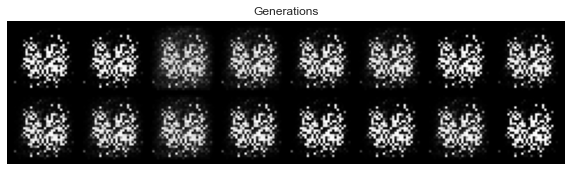

Epoch: 1, discrimiantor fake error: 0.0189, discriminator real acc: 0.986
Epoch: 2, discrimiantor fake error: 0.0284, discriminator real acc: 0.972
Epoch: 3, discrimiantor fake error: 0.0152, discriminator real acc: 0.981
Epoch: 4, discrimiantor fake error: 0.00672, discriminator real acc: 0.99
Epoch: 5, discrimiantor fake error: 0.0104, discriminator real acc: 0.991
Epoch: 6, discrimiantor fake error: 0.0466, discriminator real acc: 0.964
Epoch: 7, discrimiantor fake error: 0.0365, discriminator real acc: 0.962
Epoch: 8, discrimiantor fake error: 0.0154, discriminator real acc: 0.979
Epoch: 9, discrimiantor fake error: 0.0135, discriminator real acc: 0.983
Epoch: 10, discrimiantor fake error: 0.034, discriminator real acc: 0.968
fixed_labels_ind=tensor([8, 7, 5, 0, 8, 5, 0, 3, 3, 2, 3, 1, 9, 6, 7, 1], device='cuda:0')


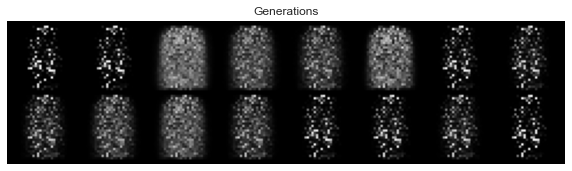

Epoch: 11, discrimiantor fake error: 0.0467, discriminator real acc: 0.956
Epoch: 12, discrimiantor fake error: 0.033, discriminator real acc: 0.963
Epoch: 13, discrimiantor fake error: 0.0287, discriminator real acc: 0.971
Epoch: 14, discrimiantor fake error: 0.0469, discriminator real acc: 0.954
Epoch: 15, discrimiantor fake error: 0.0456, discriminator real acc: 0.954
Epoch: 16, discrimiantor fake error: 0.0379, discriminator real acc: 0.961
Epoch: 17, discrimiantor fake error: 0.0411, discriminator real acc: 0.957
Epoch: 18, discrimiantor fake error: 0.0396, discriminator real acc: 0.96
Epoch: 19, discrimiantor fake error: 0.0376, discriminator real acc: 0.963
Epoch: 20, discrimiantor fake error: 0.0374, discriminator real acc: 0.963
fixed_labels_ind=tensor([8, 7, 5, 0, 8, 5, 0, 3, 3, 2, 3, 1, 9, 6, 7, 1], device='cuda:0')


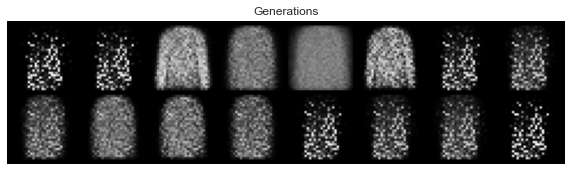

Epoch: 21, discrimiantor fake error: 0.0376, discriminator real acc: 0.962
Epoch: 22, discrimiantor fake error: 0.0445, discriminator real acc: 0.96
Epoch: 23, discrimiantor fake error: 0.0482, discriminator real acc: 0.953
Epoch: 24, discrimiantor fake error: 0.0396, discriminator real acc: 0.959
Epoch: 25, discrimiantor fake error: 0.0464, discriminator real acc: 0.959
Epoch: 26, discrimiantor fake error: 0.0445, discriminator real acc: 0.956
Epoch: 27, discrimiantor fake error: 0.0452, discriminator real acc: 0.959
Epoch: 28, discrimiantor fake error: 0.0439, discriminator real acc: 0.958
Epoch: 29, discrimiantor fake error: 0.0573, discriminator real acc: 0.947
Epoch: 30, discrimiantor fake error: 0.0653, discriminator real acc: 0.937
fixed_labels_ind=tensor([8, 7, 5, 0, 8, 5, 0, 3, 3, 2, 3, 1, 9, 6, 7, 1], device='cuda:0')


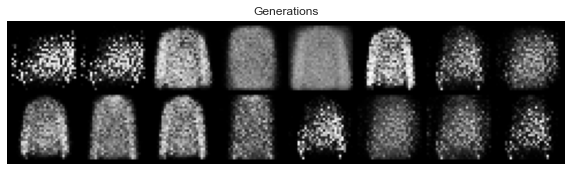

Epoch: 31, discrimiantor fake error: 0.0656, discriminator real acc: 0.938
Epoch: 32, discrimiantor fake error: 0.06, discriminator real acc: 0.939
Epoch: 33, discrimiantor fake error: 0.0618, discriminator real acc: 0.942
Epoch: 34, discrimiantor fake error: 0.0619, discriminator real acc: 0.938
Epoch: 35, discrimiantor fake error: 0.0697, discriminator real acc: 0.934
Epoch: 36, discrimiantor fake error: 0.0702, discriminator real acc: 0.931
Epoch: 37, discrimiantor fake error: 0.0721, discriminator real acc: 0.932
Epoch: 38, discrimiantor fake error: 0.0696, discriminator real acc: 0.931
Epoch: 39, discrimiantor fake error: 0.0746, discriminator real acc: 0.928
Epoch: 40, discrimiantor fake error: 0.0702, discriminator real acc: 0.93
fixed_labels_ind=tensor([8, 7, 5, 0, 8, 5, 0, 3, 3, 2, 3, 1, 9, 6, 7, 1], device='cuda:0')


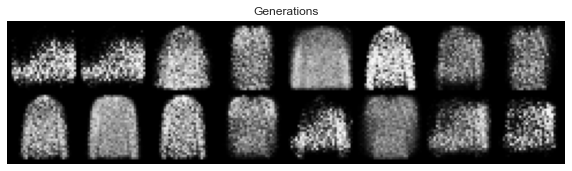

Epoch: 41, discrimiantor fake error: 0.0729, discriminator real acc: 0.933
Epoch: 42, discrimiantor fake error: 0.0838, discriminator real acc: 0.92
Epoch: 43, discrimiantor fake error: 0.0882, discriminator real acc: 0.917
Epoch: 44, discrimiantor fake error: 0.0853, discriminator real acc: 0.918
Epoch: 45, discrimiantor fake error: 0.0844, discriminator real acc: 0.919
Epoch: 46, discrimiantor fake error: 0.0806, discriminator real acc: 0.924
Epoch: 47, discrimiantor fake error: 0.0788, discriminator real acc: 0.919
Epoch: 48, discrimiantor fake error: 0.0835, discriminator real acc: 0.92
Epoch: 49, discrimiantor fake error: 0.0882, discriminator real acc: 0.91
Epoch: 50, discrimiantor fake error: 0.0919, discriminator real acc: 0.912
fixed_labels_ind=tensor([8, 7, 5, 0, 8, 5, 0, 3, 3, 2, 3, 1, 9, 6, 7, 1], device='cuda:0')


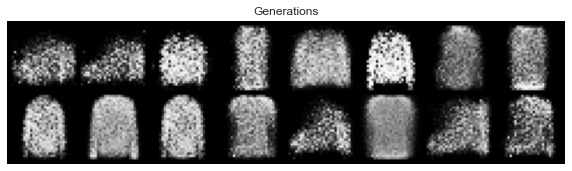

Epoch: 51, discrimiantor fake error: 0.0955, discriminator real acc: 0.905
Epoch: 52, discrimiantor fake error: 0.0959, discriminator real acc: 0.903
Epoch: 53, discrimiantor fake error: 0.0995, discriminator real acc: 0.903
Epoch: 54, discrimiantor fake error: 0.105, discriminator real acc: 0.896
Epoch: 55, discrimiantor fake error: 0.106, discriminator real acc: 0.891
Epoch: 56, discrimiantor fake error: 0.1, discriminator real acc: 0.898
Epoch: 57, discrimiantor fake error: 0.0936, discriminator real acc: 0.907
Epoch: 58, discrimiantor fake error: 0.0941, discriminator real acc: 0.909
Epoch: 59, discrimiantor fake error: 0.105, discriminator real acc: 0.895
Epoch: 60, discrimiantor fake error: 0.0991, discriminator real acc: 0.9
fixed_labels_ind=tensor([8, 7, 5, 0, 8, 5, 0, 3, 3, 2, 3, 1, 9, 6, 7, 1], device='cuda:0')


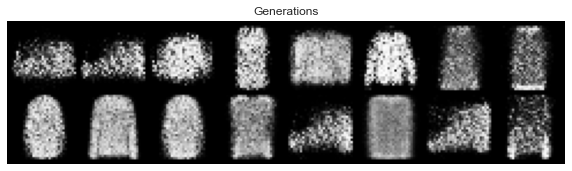

Epoch: 61, discrimiantor fake error: 0.101, discriminator real acc: 0.904
Epoch: 62, discrimiantor fake error: 0.103, discriminator real acc: 0.897
Epoch: 63, discrimiantor fake error: 0.11, discriminator real acc: 0.89
Epoch: 64, discrimiantor fake error: 0.112, discriminator real acc: 0.888
Epoch: 65, discrimiantor fake error: 0.112, discriminator real acc: 0.887
Epoch: 66, discrimiantor fake error: 0.119, discriminator real acc: 0.887
Epoch: 67, discrimiantor fake error: 0.122, discriminator real acc: 0.873
Epoch: 68, discrimiantor fake error: 0.129, discriminator real acc: 0.868
Epoch: 69, discrimiantor fake error: 0.119, discriminator real acc: 0.884
Epoch: 70, discrimiantor fake error: 0.13, discriminator real acc: 0.868
fixed_labels_ind=tensor([8, 7, 5, 0, 8, 5, 0, 3, 3, 2, 3, 1, 9, 6, 7, 1], device='cuda:0')


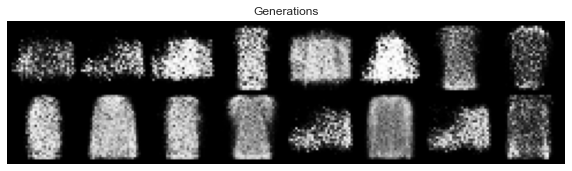

Epoch: 71, discrimiantor fake error: 0.123, discriminator real acc: 0.877
Epoch: 72, discrimiantor fake error: 0.124, discriminator real acc: 0.873
Epoch: 73, discrimiantor fake error: 0.124, discriminator real acc: 0.876
Epoch: 74, discrimiantor fake error: 0.128, discriminator real acc: 0.873
Epoch: 75, discrimiantor fake error: 0.139, discriminator real acc: 0.86
Epoch: 76, discrimiantor fake error: 0.136, discriminator real acc: 0.865
Epoch: 77, discrimiantor fake error: 0.136, discriminator real acc: 0.865
Epoch: 78, discrimiantor fake error: 0.142, discriminator real acc: 0.86
Epoch: 79, discrimiantor fake error: 0.142, discriminator real acc: 0.857
Epoch: 80, discrimiantor fake error: 0.146, discriminator real acc: 0.852
fixed_labels_ind=tensor([8, 7, 5, 0, 8, 5, 0, 3, 3, 2, 3, 1, 9, 6, 7, 1], device='cuda:0')


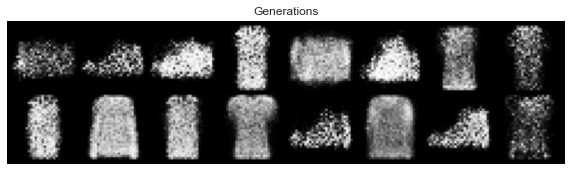

Epoch: 81, discrimiantor fake error: 0.132, discriminator real acc: 0.868
Epoch: 82, discrimiantor fake error: 0.145, discriminator real acc: 0.856
Epoch: 83, discrimiantor fake error: 0.146, discriminator real acc: 0.853
Epoch: 84, discrimiantor fake error: 0.149, discriminator real acc: 0.85
Epoch: 85, discrimiantor fake error: 0.149, discriminator real acc: 0.851
Epoch: 86, discrimiantor fake error: 0.15, discriminator real acc: 0.851
Epoch: 87, discrimiantor fake error: 0.15, discriminator real acc: 0.846
Epoch: 88, discrimiantor fake error: 0.146, discriminator real acc: 0.856
Epoch: 89, discrimiantor fake error: 0.147, discriminator real acc: 0.856
Epoch: 90, discrimiantor fake error: 0.151, discriminator real acc: 0.851
fixed_labels_ind=tensor([8, 7, 5, 0, 8, 5, 0, 3, 3, 2, 3, 1, 9, 6, 7, 1], device='cuda:0')


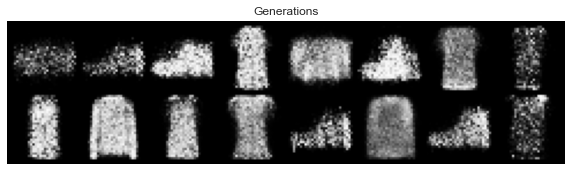

Epoch: 91, discrimiantor fake error: 0.148, discriminator real acc: 0.847
Epoch: 92, discrimiantor fake error: 0.144, discriminator real acc: 0.859
Epoch: 93, discrimiantor fake error: 0.146, discriminator real acc: 0.857
Epoch: 94, discrimiantor fake error: 0.152, discriminator real acc: 0.843
Epoch: 95, discrimiantor fake error: 0.146, discriminator real acc: 0.853
Epoch: 96, discrimiantor fake error: 0.149, discriminator real acc: 0.854
Epoch: 97, discrimiantor fake error: 0.15, discriminator real acc: 0.849
Epoch: 98, discrimiantor fake error: 0.147, discriminator real acc: 0.851
Epoch: 99, discrimiantor fake error: 0.142, discriminator real acc: 0.86


In [73]:
G_losses = []
D_losses = []
num_epochs = 100
for epoch in range(num_epochs):
    # For each batch in the dataloader
    discriminator_fake_acc = []
    discriminator_real_acc = []
    for i, data in enumerate(train_loader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator_optimizer.zero_grad()
        # Format batch
        real_images = data[0].to(device)
        y = data[1]
        y = F.one_hot(y).to(device).float()
        b_size = real_images.size(0)
        label = torch.ones((b_size,), dtype=torch.float, device=device) # Setting labels for real images -
        # Forward pass real batch through D
        output = cond_discriminator(real_images, y).view(-1)
        # Calculate loss on all-real batch
        error_discriminator_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        error_discriminator_real.backward()
        discriminator_real_acc.append(output.mean().item())

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dim,device=device)
        rand_y = torch.randint(10, (b_size,),device=device)
        rand_y = F.one_hot(rand_y, 10).float()
        # Generate fake image batch with Generator
        fake_images = cond_generator(noise, rand_y)
        label_fake = torch.zeros((b_size,), dtype=torch.float, device=device)           # fake ones with 0s
        # Classify all fake batch with Discriminator
        output = cond_discriminator(fake_images.detach(), rand_y).view(-1)
        # Calculate D's loss on the all-fake batch
        error_discriminator_fake = criterion(output, label_fake)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        error_discriminator_fake.backward()
        discriminator_fake_acc.append(output.mean().item())
        # Compute error of D as sum over the fake and the real batches
        error_discriminator = error_discriminator_real + error_discriminator_fake

        # Update D - IMPORTANT - OPTIMIZER ONLY HERE - ITS A TRICK THAT ENSURES THAT LEARNING IS BOTH ON REAL AND FAKE IMAGES AT THE SAME MOMENT
        discriminator_optimizer.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        noise = torch.randn(b_size, latent_dim, device=device)
        rand_y = torch.randint(10, (b_size,),device=device)
        rand_y = F.one_hot(rand_y, 10).float()
        fake_images = cond_generator(noise, rand_y)
        generator_optimizer.zero_grad()
        label = torch.ones((b_size,), dtype=torch.float, device=device)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = cond_discriminator(fake_images, rand_y).view(-1)
        # Calculate G's loss based on this output
        error_generator = criterion(output, label)
        # Calculate gradients for G
        error_generator.backward()
        D_G_z2 = output.mean().item()
        # Update G
        generator_optimizer.step()

        # Output training stats
        # Save Losses for plotting later
        G_losses.append(error_generator.item())
        D_losses.append(error_discriminator.item())

    print(f"Epoch: {epoch}, discrimiantor fake error: {np.mean(discriminator_fake_acc):.3}, discriminator real acc: {np.mean(discriminator_real_acc):.3}")
    generator_scheduler.step()
    discriminator_scheduler.step()
    if epoch % 10 == 0:
        with torch.no_grad():
            print(f"{fixed_labels_ind=}")
            fake = cond_generator(fixed_noise, fixed_labels).detach().cpu()
        grid = torchvision.utils.make_grid(fake)
        grid = grid.permute(1, 2, 0)
        plt.figure(figsize=(10,10))
        plt.title(f"Generations")
        plt.imshow(grid)
        plt.axis('off')
        plt.show()

In [92]:
torch.save(cond_generator.state_dict(), "models/cond_generator_1")
torch.save(cond_discriminator.state_dict(), "models/cond_discriminator_1")

In [93]:
final_cond_generator = Cond_Generator(latent_dim=latent_dim, hidden_dim=256, output_dim=784).to(device)
final_cond_generator.load_state_dict(torch.load("models/cond_generator_1"))
final_cond_discriminator = Cond_Discriminator( hidden_dim=256, input_dim=784).to(device)
final_cond_discriminator.load_state_dict(torch.load("models/cond_discriminator_1"))

<All keys matched successfully>

## Ewaluacja modeli generatywnych
Jak oceniać, że dany model generacyjny jest dobry?

### Stworzenie ewaluatora
Jest to klasyfikator 10 klas (wszystkich możliwych), nauczony na zbiorze oryginalnym.
Zauważmy, że np. przedostatnia warstwa ma na wyjściu 50 neuronów - zamieniany jest każdy obrazek wejściowy na wektor dokładnie 50 cech.
W trakcie ewluacji możemy taki wektor cech otrzymać dla obrazka oryginalnego i analogicznego obrazka sztucznego i badać różnice między tymi wektorami.

In [94]:
class Evaluator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Evaluator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, 50)
        self.fc_out  = nn.Linear(50, 10)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def get_features(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        return x

    def forward(self, x):
        x = self.get_features(x)
        x = self.fc_out(x)
        return x

evaluator = Evaluator(28*28, 256).to(device)

In [95]:
# Optimizers
optimizer = torch.optim.Adam(evaluator.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.97)

# loss
criterion = nn.CrossEntropyLoss()

In [96]:
num_epochs = 7
for epoch in range(num_epochs):
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        results = evaluator(data)
        loss = criterion(results, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [97]:
num_correct = 0
total_guesses = 0

evaluator.eval()
with torch.no_grad():
    for data, targets in iter(test_loader):
        # Sends data and targets to device
        data = data.to(device)
        targets = targets.to(device)

        # Acquires the network's best guesses at each class
        results = evaluator(data)
        best_guesses = torch.argmax(results, 1)

        # Updates number of correct and total guesses
        num_correct += torch.eq(targets, best_guesses).sum().item()
        total_guesses += len(targets)

print("Correctly guessed ", num_correct/total_guesses*100, "% of the dataset")

Correctly guessed  87.08 % of the dataset


In [98]:
vae = VAE(latent_dim=32, hidden_dim=256, x_dim=784).to(device)
vae.load_state_dict(torch.load("models/vae_1"))

<All keys matched successfully>

In [99]:
with torch.no_grad():
    fixed_noise = torch.randn(1000, latent_dim,device=device)
    fixed_labels = torch.randint(10,(1000,),device=device)
    fixed_labels = F.one_hot(fixed_labels, 10).float()
    generations_cond_gan = cond_generator(fixed_noise, fixed_labels)
    generations_gan = generator(fixed_noise)
    generations_vae = vae.decoder(fixed_noise)

In [100]:
orig_data = [x[0] for x in list(test_set)[:1000]]
orig_data = torch.cat(orig_data)

In [101]:
with torch.no_grad():
    dist_orig_data = evaluator.get_features(orig_data.to(device)).cpu()
    dist_vae = evaluator.get_features(generations_vae.to(device)).cpu()
    dist_gan = evaluator.get_features(generations_gan.to(device)).cpu()
    dist_cond_gan = evaluator.get_features(generations_cond_gan.to(device)).cpu()

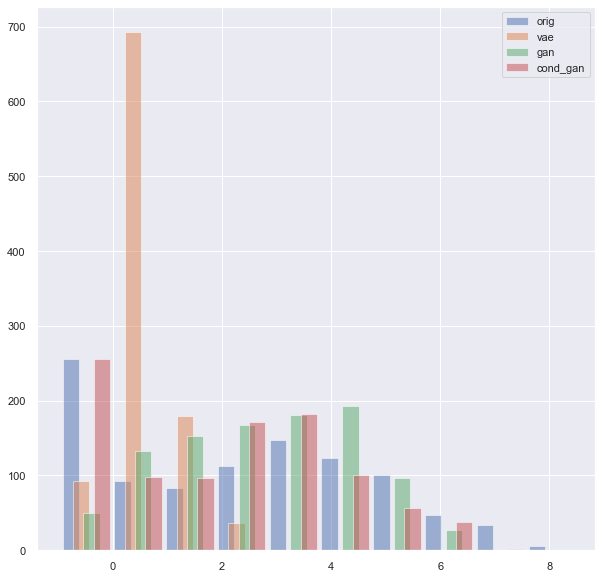

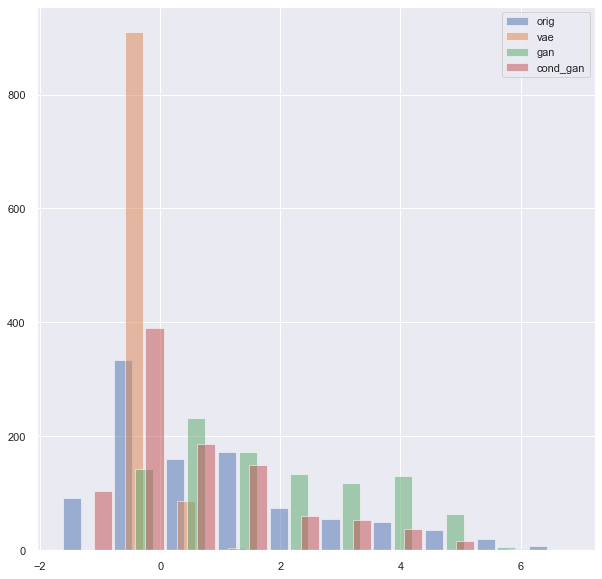

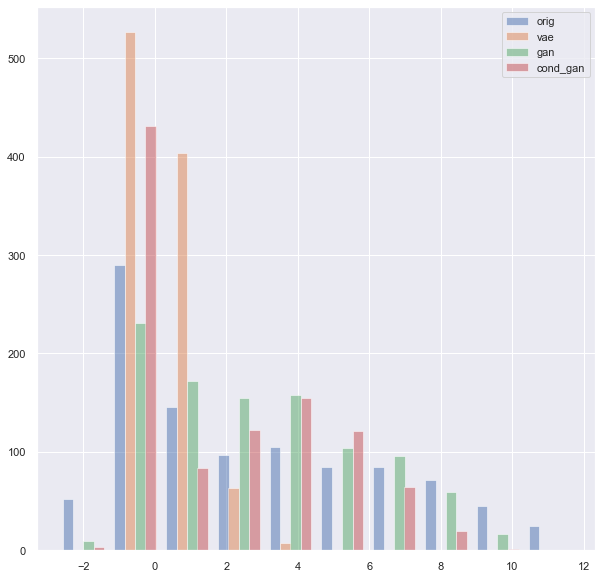

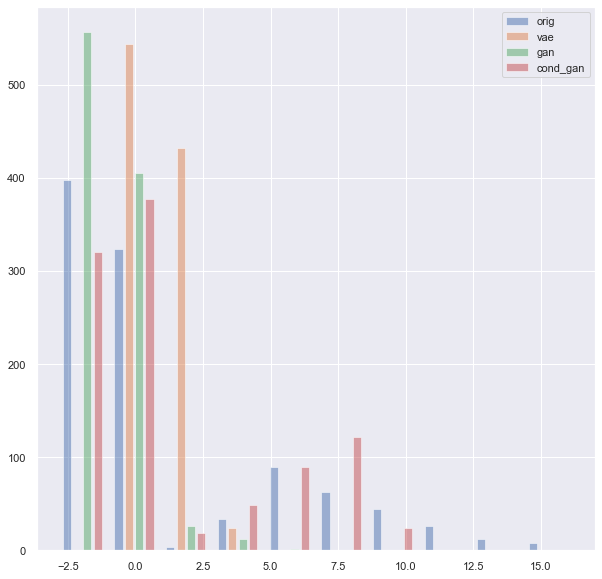

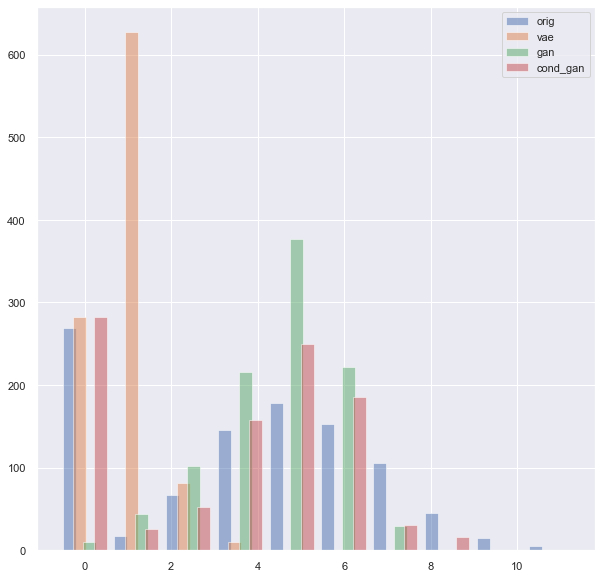

In [102]:
for idx in range(5):
    bins = 10
    w = 0.3
    plt.figure(figsize=(10,10))
    plt.hist([dist_orig_data[:,idx].numpy(),dist_vae[:,idx].numpy(),dist_gan[:,idx], dist_cond_gan[:,idx]], bins, alpha=0.5, label=['orig','vae','gan','cond_gan'],width=w)
    plt.legend(loc='upper right')
    plt.show()
    plt.close()

### Odległość Fletcheta

In [103]:
######### Frechet Inception distance based on implementation from https://github.com/mseitzer/pytorch-fid

import numpy as np
from scipy import linalg


def calculate_frechet_distance(distribution_1, distribution_2, eps=1e-6):
    mu1 = np.mean(distribution_1, axis=0)
    sigma1 = np.cov(distribution_1, rowvar=False)

    mu2 = np.mean(distribution_2, axis=0)
    sigma2 = np.cov(distribution_2, rowvar=False)

    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [104]:
orig_data_2 = [x[0] for x in list(test_set)[-1000:]]
orig_data_2 = torch.cat(orig_data_2)
with torch.no_grad():
    dist_orig_data_2 = evaluator.get_features(orig_data_2.to(device)).cpu()

In [105]:
for name, obj in zip(['orig','vae','gan','cond_gan'],[dist_orig_data_2.numpy(),dist_vae.numpy(),dist_gan.numpy(), dist_cond_gan.numpy()]):
    print(f"FD {name}: {calculate_frechet_distance(dist_orig_data.numpy(),obj)}")

FD orig: 1.9237398342282859
FD vae: 346.71353439465236
FD gan: 133.14628495329407
FD cond_gan: 30.026888263486512


Dla bardziej złożonych obrazów przyjęto inną metodę - FID.